# Predictions for fantasy baseball
Author: Matthias Kullowatz  
Date: July, 2023

## Overview

Millions of people play fantasy baseball and typically select players for their team through classic drafts or auctions. Choosing a team based on your favorite players--or simply on last year's performance without any regard for regression to the mean--is likely to field a weaker team. Baseball is one of the most well documented of all sports, statistics-wise. With the wealth of collected information, you can derive a better estimate of each player's true talent level and their likely performance in the coming year using machine learning. This allows for better drafting and also helps avoid overpaying for players coming off of "career" seasons.

When drafting players for fantasy baseball, you must make decisions based on the player's performance over their career to date, as well as effects like aging. Basing evaluation on personal interpretation of the player's performance is likely to cause you to overvalue a player's most recent performance. In other words, it's common to overvalue a player coming off a career year or undervalue a player coming off a bad year. The goal is to generate a better prediction of the player's performance in the next year based on what he has done in prior years, and from patterns you can learn from similar players in the past. If you build a machine learning model to predict a player's performance in the next year based on their previous performance, it will help you identify when these over- or under-performances are flukes versus when they are actual indicators of that player’s future performance. Further you'll be able to create ranked lists by position to help you on draft day.

### What you will learn

* How to query a rich dataset of MLB players from Fangraphs' API
* How to set up a project with automated time-aware feature engineering ([Automated Feature Discovery](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-time.html))
* How to update the player data (i.e., secondary data) to re-predict without building a new project
* How to loop over a project creation function to build many DataRobot projects automatically

### Retrieve baseball data
This notebook uses the `pybaseball` module to get player seasons from 2012 through 2023. In this workflow, the machine learning algorithm learns patterns from the pre-COVID era of data as well as data from 2020 and 2021. This data should help show how well the top model is able to learn how to work around a shortened season. 

Fangraphs provides more than 300 features about players each season, from the most superficial statistics like batting average (`AVG`) and home run counts (`HR`), to the most in-depth statistics like expected weighted on-base average (`xWOBA`) and barrel contact percentage (`Barrel%`). DataRobot sifts through many of these feature to find the ones that signal future performance best.

For this notebook, the focus is on predicting class fantasy hitters' statistics, including batting average (`AVG`), home runs (`HR`), runs (`R`), runs batted in (`RBI`), and stolen bases (`SB`). Batting average is a common statistic used in all fantasy baseball league types. It is a rate statistic, rather than a total like home runs, so you can leverage many rate statistic features of players and mostly avoid volume statistics outside of plate appearances (`PA`).

## Setup

This accelerator assumes that the DataRobot Python client package has been installed and configured with the credentials of a DataRobot user with API access permissions. It also utilizes the `pybaseball` module which scrapes data from Fangraphs.com, a popular baseball website with many statistics and a publicly available API. The following steps import the required libraries.

### Import libraries

In [1]:
# only if it has not yet been installed
#!pip install pybaseball

In [2]:
import datetime
from datetime import datetime
import time

import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pybaseball
from pybaseball import batting_stats

In [3]:
dr.__version__

'3.1.0'

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the Python client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [8]:
dr.Client(config_path="drconfig.yaml")

### Import player batting data
Starting in 2007, Pitch Info Solutions started keeping track of some advanced pitch-by-pitch metrics for batters and pitchers, making it a good year to start model training. The data is collected the data in multiple chunks to not overwhelm the Fangraphs API. This should only take a few minutes.

In [4]:
%%time
batters_training_2007_2011 = batting_stats(2007, 2011, qual=1, split_seasons=True)
batters_training_2012_2016 = batting_stats(2012, 2016, qual=1, split_seasons=True)
batters_training_2017_2021 = batting_stats(2017, 2021, qual=1, split_seasons=True)
batters_training_2022_2023 = batting_stats(2022, 2023, qual=1, split_seasons=True)
batters_training = pd.concat(
    [
        batters_training_2007_2011,
        batters_training_2012_2016,
        batters_training_2017_2021,
        batters_training_2022_2023,
    ],
    axis=0,
)

CPU times: user 29.6 s, sys: 3.97 s, total: 33.6 s
Wall time: 2min 27s


In [5]:
batters_training.to_csv("batters_training_data_raw.csv")
print(batters_training.shape)
batters_training.head()

(15387, 319)


,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Barrel%,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA
166,1274,2007,Alex Rodriguez,NYY,31,158,583,708,183,98,...,NaN,NaN,0.0,NaN,0,0.157,0.257,NaN,NaN,NaN
280,4727,2011,Jacoby Ellsbury,BOS,27,158,660,732,212,129,...,NaN,NaN,0.0,NaN,0,0.194,0.254,NaN,NaN,NaN
112,1177,2008,Albert Pujols,STL,28,148,524,641,187,106,...,NaN,NaN,0.0,NaN,0,0.159,0.199,NaN,NaN,NaN
249,7435,2009,Ben Zobrist,TBR,28,152,501,599,149,87,...,NaN,NaN,0.0,NaN,0,0.194,0.261,NaN,NaN,NaN
363,4810,2008,Brian McCann,ATL,24,145,509,573,153,87,...,NaN,NaN,0.0,NaN,0,0.143,0.210,NaN,NaN,NaN


### Data preparation

The cells below select a smaller subset of features from the 319 and perform some very light feature engineering to create additional baserunning features. Neither of these tasks are necessary, though Feature Discovery would take longer on all 319 features. Set the "Date" column to the first of March each year, which is before the season begins, and DataRobot will use this Date column to make sure that all derived features for each player were recorded before the season in question. This avoids leaking information into the predictions that you wouldn't actually have access to at prediction time, such as using a player's slugging percentage in a given season to "predict" his home run totals in <i>that same</i> season.

### Weights
Use an "instance weight" on the models' optimization function so that the models can learn more from players with greater sample size. Use the square root of plate appearances, stemming from the fact that standard error shrinks inversely with the square root of the sample size. An alternative to this approach would be to limit the training set to only those seasons with at least X plate appearances, though that introduces its own set of arbitrariness and issues. Note that weights are only needed in model training and have no effect come scoring time.

In [6]:
# Select target metrics for prediction
target_metrics = ["AVG", "HR", "SB", "R", "RBI"]

In [7]:
def data_prep(df):
    df = df.copy(deep=True)
    df["Date"] = [str(year) + "-03-01" for year in df["Season"]]
    # create COVID indicator to help models learn around the shortened season
    df["COVID"] = [1 if year == 2020 else 0 for year in df["Season"]]
    df = df[
        target_metrics
        + [  # Basic info
            "IDfg",
            "Season",
            "Name",
            "Date",
            "COVID",
            "Age",
            "PA",
            # Superficial rates
            "BB%",
            "K%",
            "OBP",
            "SLG",
            "ISO",
            # Expected rates based on batted ball data
            "xBA",
            "Barrel%",
            "maxEV",
            "xSLG",
            "Oppo%",
            "HR/FB",
            "IFFB%",
            "xwOBA",
            # Plate discipline
            "CStr%",
            "SwStr%",
            "O-Swing% (pi)",
            "Z-Swing% (pi)",
            "O-Contact% (pi)",
            "Z-Contact% (pi)",
            "Zone% (pi)",
            # Speed + position adjustment
            "CS",
            "BsR",
            "Pos",
        ]
    ]
    df["SB%"] = df["SB"] / (df["SB"] + df["CS"])
    df["SB/PA"] = df["SB"] / (df["PA"])
    df["BsR/PA"] = df["BsR"] / (df["PA"])

    # Scale counting stats (e.g., PA, HR, etc.) to the season's highest total
    # to better adjust for COVID-shortened season
    counting_stats = ["PA", "HR", "SB", "CS", "R", "RBI"]
    for stat in counting_stats:
        max_stat = pd.DataFrame(df.groupby("Season")[stat].max())
        max_stat.rename(columns={f"{stat}": f"{stat}_max"}, inplace=True)
        df = pd.merge(df, max_stat, how="left", on="Season")
        df[f"{stat}_scaled"] = df[f"{stat}"] / df[f"{stat}_max"]

    df["weight"] = np.sqrt(df["PA"])

    return df


batters_training = data_prep(batters_training)

## Modeling with Feature Discovery

Create a DataRobot project to train many models against the assembled dataset. Then you will leverage [Feature Discovery](https://docs.datarobot.com/en/docs/data/transform-data/feature-discovery/fd-time.html), an automated feature engineering tool in DataRobot, which will use the secondary dataset created above to derive rolling, time-aware features about players' recent performance history. In this example, DataRobot looks back up to three seasons to derive a player's recent performance, though it's worth testing longer and shorter feature derivation windows.

Wrap this all into a function so that it can be repeated for all fantasy hitting metrics--right after you register the training data in DataRobot's AI Catalog--and then you'll use it in the project as a "secondary dataset." A secondary dataset can contain just about any feature that you think will improve the predictions. As noted above, each of these features will get aggregated at the player-level over rolling windows.

### Primary and secondary datasets

Create primary and secondary datasets for DataRobot's Feature Discovery (automated feature engineering). A primary dataset should contain the following pieces of information:

1. The joining key(s) that specificy the level of granularity at which you want to generate features. Use the player's ID, because you want to derive rolling prior performance features at the player-level.
2. The temporal/timestamp column. This is what DataRobot will use to derive rolling, time-based feature derivation windows from the secondary dataset. 
3. Any static or deterministic features that would be available at the moment of prediction, such as the player's expected position (in most cases), age, physical attributes, etc. 
4. The target feature to be predicted.
</ol><br>
A secondary dataset can contain just about any feature that you think will improve the predictions. Each of these features will get aggregated at the player-level over rolling windows in this project, or more generally it will be aggregated across the joining key(s). 

In [9]:
# Register secondary dataset in AI Catalog
secondary_dataset_object = dr.Dataset.create_from_in_memory_data(
    data_frame=batters_training, fname="fantasy_baseball_batters_secondary"
)

In [10]:
# Define function to build a projecct with Feature Discovery based on some basic inputs


def run_feature_discovery_project(
    target,
    primary_dataset,
    secondary_dataset_object,
    join_keys,
    primary_timestamp,
    secondary_timestamp,
):
    # Optional: Define the aggregation functions to be used when generating new features
    # Default settings are often effective, but this will save you some time
    feature_discovery_settings_configs = [
        {"name": "enable_days_from_prediction_point", "value": False},
        {"name": "enable_hour", "value": False},
        {"name": "enable_categorical_num_unique", "value": False},
        {"name": "enable_categorical_statistics", "value": False},
        {"name": "enable_numeric_minimum", "value": True},
        {"name": "enable_token_counts", "value": False},
        {"name": "enable_latest_value", "value": True},
        {"name": "enable_numeric_standard_deviation", "value": False},
        {"name": "enable_numeric_skewness", "value": False},
        {"name": "enable_day_of_week", "value": False},
        {"name": "enable_entropy", "value": False},
        {"name": "enable_numeric_median", "value": False},
        {"name": "enable_word_count", "value": False},
        {"name": "enable_pairwise_time_difference", "value": False},
        {"name": "enable_days_since_previous_event", "value": False},
        {"name": "enable_numeric_maximum", "value": True},
        {"name": "enable_numeric_kurtosis", "value": False},
        {"name": "enable_most_frequent", "value": False},
        {"name": "enable_day", "value": False},
        {"name": "enable_numeric_average", "value": True},
        {"name": "enable_summarized_counts", "value": False},
        {"name": "enable_missing_count", "value": True},
        {"name": "enable_record_count", "value": True},
        {"name": "enable_numeric_sum", "value": False},
    ]

    # Define relationships between datasets and rolling "feature derivation" windows
    # Choose combinations of the past three years
    dataset_definitions = [
        {
            "identifier": "sec_1_2_3",
            "catalogVersionId": secondary_dataset_object.version_id,
            "catalogId": secondary_dataset_object.id,
            # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
            "primaryTemporalKey": primary_timestamp,
            "snapshotPolicy": "latest",
        },
        {
            "identifier": "sec_2",
            "catalogVersionId": secondary_dataset_object.version_id,
            "catalogId": secondary_dataset_object.id,
            # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
            "primaryTemporalKey": primary_timestamp,
            "snapshotPolicy": "latest",
        },
        {
            "identifier": "sec_3",
            "catalogVersionId": secondary_dataset_object.version_id,
            "catalogId": secondary_dataset_object.id,
            # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
            "primaryTemporalKey": primary_timestamp,
            "snapshotPolicy": "latest",
        },
        {
            "identifier": "sec_2_3",
            "catalogVersionId": secondary_dataset_object.version_id,
            "catalogId": secondary_dataset_object.id,
            # "feature_list_id": secondary_dataset_featurelist.id, # default is Informative features
            "primaryTemporalKey": primary_timestamp,
            "snapshotPolicy": "latest",
        },
    ]

    relationships = [
        {
            "dataset2Identifier": "sec_1_2_3",
            "dataset1Keys": join_keys,
            "dataset2Keys": join_keys,
            "featureDerivationWindowStart": -3,
            "featureDerivationWindowEnd": 0,
            "featureDerivationWindowTimeUnit": "YEAR",
            "predictionPointRounding": 1,
            "predictionPointRoundingTimeUnit": "SECOND",
        },
        {
            "dataset2Identifier": "sec_2",
            "dataset1Keys": join_keys,
            "dataset2Keys": join_keys,
            "featureDerivationWindowStart": -2,
            "featureDerivationWindowEnd": -1,
            "featureDerivationWindowTimeUnit": "YEAR",
            "predictionPointRounding": 1,
            "predictionPointRoundingTimeUnit": "SECOND",
        },
        {
            "dataset2Identifier": "sec_3",
            "dataset1Keys": join_keys,
            "dataset2Keys": join_keys,
            "featureDerivationWindowStart": -3,
            "featureDerivationWindowEnd": -2,
            "featureDerivationWindowTimeUnit": "YEAR",
            "predictionPointRounding": 1,
            "predictionPointRoundingTimeUnit": "SECOND",
        },
        {
            "dataset2Identifier": "sec_2_3",
            "dataset1Keys": join_keys,
            "dataset2Keys": join_keys,
            "featureDerivationWindowStart": -3,
            "featureDerivationWindowEnd": -1,
            "featureDerivationWindowTimeUnit": "YEAR",
            "predictionPointRounding": 1,
            "predictionPointRoundingTimeUnit": "SECOND",
        },
    ]

    relationship_config = dr.RelationshipsConfiguration.create(
        dataset_definitions=dataset_definitions,
        relationships=relationships,
        feature_discovery_settings=feature_discovery_settings_configs,
    )

    # Set up specific backtest segments
    partitioning_spec = dr.DatetimePartitioningSpecification(
        datetime_partition_column="Date",
        gap_duration="P1Y",
        # By setting start date to 2021-03-02, make sure to include the 2022 season which is dated 2022-03-01
        holdout_start_date=datetime(2021, 3, 2),
        holdout_duration="P1Y",
        number_of_backtests=2,
        use_time_series=False,
    )

    # Set the backtest partitions
    partitioning_spec.backtests = [
        dr.BacktestSpecification(
            0,  # backtest 1 index
            gap_duration="P0Y",
            # By setting start date to 2020-03-02, make sure to include the 2021 season which is dated 2021-03-01
            validation_start_date=datetime(2020, 3, 2),
            validation_duration="P1Y",
        ),
        dr.BacktestSpecification(
            1,  # backtest 2 index
            gap_duration="P0Y",
            # By setting start date to 2018-03-02, make sure to include the 2019 season which is dated 2019-03-01
            validation_start_date=datetime(2018, 3, 2),
            validation_duration="P1Y",
        ),
        # Input other backtest periods below if desired
        #     dr.BacktestSpecification(
        #       1, # backtest 2 index
        #       gap_duration = 'P0Y',
        #       validation_start_date=datetime(2017,3,2),
        #       validation_duration = 'P1Y')
    ]

    # Create advanced options object with weights and blenders
    advanced_options = dr.AdvancedOptions(
        weights="weight",
        blend_best_models=True,
        consider_blenders_in_recommendation=True,
    )

    # Create a project and pass in data
    project = dr.Project.create(
        sourcedata=batters_training,
        project_name=f"{target} Predictions for Fantasy Baseball: 2010 - 2022",
        dataset_filename="batters_primary",
    )

    primary_featurelist = project.create_featurelist(
        "Primary model features", ["COVID", "Age", "Pos"]
    )

    # Start project
    project.analyze_and_model(
        target=target,
        mode=dr.AUTOPILOT_MODE.QUICK,
        worker_count=-1,
        advanced_options=advanced_options,
        partitioning_method=partitioning_spec,
        featurelist_id=primary_featurelist.id,
        relationships_configuration_id=relationship_config.id,
        max_wait=3600,  # Allow up to an hour for pre-processing before timeout
    )

    return project

### Create primary dataset and feature list

In the function above, you selected just a few features for our project's feature list. If you haven't used Feature Discovery, then this might seem strange: how can you predict baseball player performance with only a COVID indicator, age, and their position? Recall that you have all loaded the secondary dataset and some feature engineering relationship configurations in the same function, which is going to do all the heavy feature engineering lifting for you in this project. DataRobot will create hundreds of rolling, time-aware features for each player for each season, but there are still certain features that should explicitly be part of the primary dataset's featurelist and left un-engineered. In general, a primary dataset should contain the following pieces of information:

1. The joining key(s) that specificy the level of granularity at which you want to generate features. Use the player's ID, because you want to derive rolling prior performance features at the player-level.
2. The temporal/timestamp column. This is what DataRobot will use to derive rolling, time-based feature derivation windows from the secondary dataset. 
3. Any static or deterministic features that would be available at the moment of prediction, such as the player's expected position (in most cases), age, physical attributes, etc. These are values that may change over time, but change in predictable, non-random ways. 

### Loop over the target metrics and create a project for each
This will take some hours, so it's best to run overnight. Train starting in the 2010 season--which allows for three years of look-back data for that first season (and every subsequent training season)--and leave out the partially completed 2023 season. Also note that you retain the project objects for later in a list.

In [11]:
%%time
projects = []
for target in target_metrics:
    projects.append(
        run_feature_discovery_project(
            target=target,
            primary_dataset=batters_training[
                (batters_training["Season"] >= 2010)
                & (batters_training["Season"] < 2023)
            ],
            secondary_dataset_object=secondary_dataset_object,
            join_keys=["IDfg"],
            primary_timestamp="Date",
            secondary_timestamp="Date",
        )
    )
print(projects)

[Project(AVG Predictions for Fantasy Baseball: 2010 - 2022), Project(HR Predictions for Fantasy Baseball: 2010 - 2022), Project(SB Predictions for Fantasy Baseball: 2010 - 2022), Project(R Predictions for Fantasy Baseball: 2010 - 2022), Project(RBI Predictions for Fantasy Baseball: 2010 - 2022)]
CPU times: user 7.57 s, sys: 3.22 s, total: 10.8 s
Wall time: 1h 34min 37s


#### Wait for Autopilot to finish in all projects
Pausing the Python interpreter to wait for Autopilot to complete is important when you have other things you want to do in the same script/notebook. Use this opportunity to unlock the holdout in all projects. 

In [12]:
%%time
for p in projects:
    p.wait_for_autopilot(check_interval=120)
    p.unlock_holdout()

In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 0s)
In progress: 0, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 0s)
In progress: 8, queued: 0 (waited: 1s)
In progress: 8, queued: 0 (waited: 2s)
In progress: 8, queued: 0 (waited: 3s)
In progress: 8, queued: 0 (waited: 5s)
In progress: 8, queued: 0 (waited: 7s)
In progress: 8, queued: 0 (waited: 11s)
In progress: 8, queued: 0 (waited: 18s)
In progress: 7, queued: 0 (waited: 32s)
In progress: 3, queued: 0 (waited: 58s)
In progress: 2, queued: 0 (waited: 110s)
In progress: 1, queued: 0 (waited: 213s)
In progress: 0, queued: 0 (waited: 686s)
CPU times: user 436 ms, sys: 81.3 ms, total: 517 ms
Wall time: 11min 31s


#### View project in UI

If you want to view the project in the DataRobot UI, use the following snippet to retrieve the project's URL and use it to navigate to the application.

In [13]:
# Get project URL
project_url = projects[0].get_uri()
print(project_url)

https://app.datarobot.com/projects/64b57d1b966c487dbfd5f36d/models


## Make predictions

Use the batting average model as an example of how to update the player data (i.e., secondary dataset) and make new predictions. 

### Through model Leaderboard

After determining the top-performing model from the Leaderboard, upload a prediction test dataset to verify that the model generates predictions successfully. Can use these predictions as is, though you don't get any of the benefits of DataRobot's AI Production (artist formerly known as MLOps). Check out some quick, informative videos on AI Production functionality [here](https://www.youtube.com/playlist?list=PLe-6XGmzriIiryqU60sOI2ioInkBSpcCB).  
<br>
The predictions are returned as a Pandas dataframe. Here, you have some 2023 data to test on. While it's not completely fair to our model to test on only a half season of data--what you have today as of July, 2023--you should still expect the model to do decently well at sorting the players best-to-worst.

### Scoring consideration
In many cases, as in fantasy sports, you want to make your predictions during the offseason, when there is no data available for the upcoming season. In these cases, you will need to create a new primary dataset from the most recent season's observations. For sports, here is a common workflow:
1. Extract distinct player IDs from the most recent season(s). 
2. Update all known-in-advance features (such as age, position, team) as appropriate.
3. Feed this updated primary dataset in as the `scoring_data` in the examples below. 

## Secondary dataset maintenance
You queried data all the way into the 2023 season, so to predict the 2023 season, you have everything you need. However, in many cases, the secondary datasets need to be updated in production. Here you'll (unnecessarily) update the secondary dataset for scoring for example's sake.

In [14]:
# Select top batting average model
project = [p for p in projects if "AVG" in p.project_name][0]
rec_model = project.recommended_model()
rec_model

DatetimeModel('AVG Blender')

In [15]:
# scoring_data = batters_training[batters_training['Season' == 2023]].copy()
scoring_data = batting_stats(2023, 2023, qual=1)

# Prep the data with our function from above
scoring_data = data_prep(scoring_data)
scoring_data.to_csv(f"AVG_scoring_data_{datetime.today()}.csv")
scoring_data.head()

,AVG,HR,SB,R,RBI,IDfg,Season,Name,Date,COVID,...,HR_scaled,SB_max,SB_scaled,CS_max,CS_scaled,R_max,R_scaled,RBI_max,RBI_scaled,weight
0,0.333,23,43,82,58,18401,2023,Ronald Acuna Jr.,2023-03-01,0,...,0.676471,43,1.000000,9,0.777778,82,1.000000,80,0.7250,20.566964
1,0.286,27,7,74,65,13611,2023,Mookie Betts,2023-03-01,0,...,0.794118,43,0.162791,9,0.222222,82,0.902439,80,0.8125,20.273135
2,0.301,34,11,67,73,19755,2023,Shohei Ohtani,2023-03-01,0,...,1.000000,43,0.255814,9,0.444444,82,0.817073,80,0.9125,20.346990
3,0.276,27,8,63,56,20043,2023,Luis Robert,2023-03-01,0,...,0.794118,43,0.186047,9,0.222222,82,0.768293,80,0.7000,19.672316
4,0.295,17,0,42,55,19352,2023,Sean Murphy,2023-03-01,0,...,0.500000,43,0.000000,9,0.000000,82,0.512195,80,0.6875,16.733201


### Option 1
In production, whether you are predicting through the modeling workers (as you are) or through a deployment, it is typically easiest to simply update the secondary dataset with new data in a new version. When you set up the secondary dataset relationships before model training, you set the "snapshot policy" to "latest", which means that any prediction will leverage the most recent version of the secondary dataset(s) in the AI Catalog. Technically you only need three years of data (2020-2022) to make a prediction for 2023, because you selected up to a 3-year feature derivation window in the project setup. 

In [16]:
new_secondary_df = batting_stats(2020, 2022, qual=1)
new_secondary_df = data_prep(new_secondary_df)
# Overwrite the prior secondary dataset, both the Python object and in the AI Catalog
secondary_dataset_object = dr.Dataset.create_version_from_in_memory_data(
    dataset_id=secondary_dataset_object.id,
    data_frame=new_secondary_df,
    read_timeout=3600,
    max_wait=3600,
)

#### Option 1: request predictions

In [17]:
prediction_dataset = project.upload_dataset(
    sourcedata=scoring_data,
)
predict_job = rec_model.request_predictions(prediction_dataset.id)

predictions = predict_job.get_result_when_complete()
predictions = pd.concat([scoring_data, predictions], axis=1)

### Option 2
Though option 1 is easier and more popular, there are times when you'd like to preserve the secondary dataset for training as is, and create a new secondary dataset entry in the AI Catalog with updated information. Note that you need to make sure to match the identifiers that you used in model training with Feature Discovery above. 

In [18]:
# Generate a new secondary configuration for updated predictions
new_secondary_catalog = dr.Dataset.create_from_in_memory_data(
    data_frame=new_secondary_df
)
new_secondary_catalog.modify(name=f"PlayerSecondaryUpdate_for_scoring")

# Create one secondary dataset object for each one created in model training
new_secondary_object = []
for idfr in ["sec_1_2_3", "sec_2", "sec_3", "sec_2_3"]:
    new_secondary_temp = dr.SecondaryDataset(
        identifier=idfr,
        catalog_id=new_secondary_catalog.id,
        catalog_version_id=new_secondary_catalog.version_id,
        snapshot_policy="latest",
    )
    new_secondary_object.append(new_secondary_temp)

new_secondary_data_config = dr.SecondaryDatasetConfigurations.create(
    project_id=project.id,
    name=f"secondary_config_for_scoring",
    secondary_datasets=new_secondary_object,
)

#### Option 2: request predictions
When you upload the primary dataset for scoring--as you would with a typical DataRobot project--you also must upload the new secondary configuration you just made. Note again that this is only necessary if your secondary data has gone stale, which is more common in use cases where scoring happens frequently. 

In [19]:
prediction_dataset2 = project.upload_dataset(
    sourcedata=scoring_data, secondary_datasets_config_id=new_secondary_data_config.id
)
predict_job2 = rec_model.request_predictions(prediction_dataset2.id)

predictions2 = predict_job2.get_result_when_complete()
predictions2 = pd.concat([scoring_data, predictions2], axis=1)

In [20]:
# Confirm that both prediction sets are 100% (1.0) the same
np.mean(np.array(predictions.prediction == predictions2.prediction))

1.0

## Evaluate predictions

### Top 10 players

Take a look at some of the players with the best predictions for 2023 (`prediction`), and how they are actually doing so far (`AVG`).

In [21]:
# View top players by batting average prediction vs. actual
predictions_250PA = predictions[predictions["PA"] > 250].copy()
predictions_250PA.sort_values("prediction", ascending=False)[
    ["Name", "Age", "AVG", "prediction"]
].head(10)

,Name,Age,AVG,prediction
5,Freddie Freeman,33,0.314,0.303339
24,Luis Arraez,26,0.380,0.297312
25,Paul Goldschmidt,35,0.285,0.285442
19,Bo Bichette,25,0.317,0.284319
149,Bryce Harper,30,0.300,0.283388
100,Trea Turner,30,0.249,0.279526
105,Steven Kwan,25,0.270,0.279461
68,Alex Verdugo,27,0.286,0.277932
79,Justin Turner,38,0.291,0.277662
49,Xander Bogaerts,30,0.258,0.277037


### Lift chart

#### Create and view lift chart table

In [22]:
# Create lift chart table for predictions vs. actuals
predictions_250PA["predicted_bucket"] = pd.qcut(predictions_250PA["prediction"], 10)
pred_lift_chart = (
    predictions_250PA.copy()
    .sort_values("prediction", ascending=False)
    .groupby("predicted_bucket")
    .agg({"prediction": ["count", "mean"], "AVG": "mean", "PA": "mean"})
)
pred_lift_chart

prediction                 AVG          PA
                      count      mean      mean        mean
predicted_bucket                                           
(0.207, 0.225]           20  0.219473  0.231350  302.600000
(0.225, 0.234]           19  0.230035  0.243842  336.315789
(0.234, 0.239]           19  0.237534  0.247895  309.315789
(0.239, 0.244]           19  0.241631  0.263895  331.526316
(0.244, 0.25]            19  0.246797  0.254158  328.368421
(0.25, 0.254]            19  0.251736  0.259316  354.631579
(0.254, 0.259]           19  0.256366  0.266158  347.947368
(0.259, 0.265]           19  0.261868  0.259684  333.578947
(0.265, 0.272]           19  0.268049  0.272421  370.315789
(0.272, 0.303]           19  0.279451  0.287211  369.000000

#### View lift chart plot
You see that the lower predicted players are doing worse and the higher predicted players are doing better, for the most part, and that's the important part in fantasy baseball. You don't have to outrun the bear; you just have to outrun everyone else. The fact that the actual batting averages are running higher than the predicted batting averages does actually make sense, too, due to some sampling biases:
1. First, you are only taking players with at least 250 plate appearances through mid-July. These are the players whom managers have chosen to play the most, and are likely being selected <i>because</i> they are playing better. 
2. Additionally, with only half a season, the volatility of outcomes is greater than what was trained on with full seasons. This will also inflate the highest batting averages in this chart. 

Text(0, 0.5, 'Actual AVG')

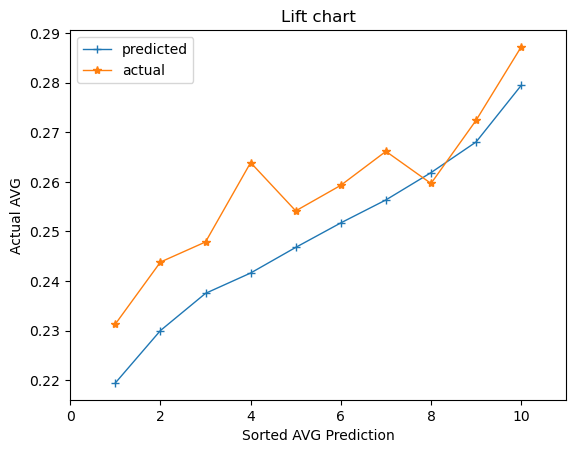

In [23]:
# Set styling
dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"
dr_light_blue = "#3CA3E8"

# Plot lift chart table
plt.clf()
plt.plot(
    range(1, len(pred_lift_chart) + 1),
    pred_lift_chart["prediction"]["mean"],
    marker="+",
    lw=1,
    color=dr_blue,
    label="predicted",
)
plt.plot(
    range(1, len(pred_lift_chart) + 1),
    pred_lift_chart["AVG"]["mean"],
    marker="*",
    lw=1,
    color=dr_orange,
    label="actual",
)
plt.xlim([0, len(pred_lift_chart) + 1])
plt.legend(loc="best")
plt.title("Lift chart")
plt.xlabel("Sorted AVG Prediction")
plt.ylabel("Actual AVG")

For a more in-depth example on customizing lift charts, check out [this AI Accelerator](https://github.com/datarobot-community/ai-accelerators/blob/main/advanced-experimentation/customizing_lift_charts/customizing_lift_charts.ipynb). 

## Conclusion
ML experimentation requires building multiple models for a variety of reasons. For example, DataRobot's Autopilot already builds many models to identify the best combination of pre-processing steps, fitting algorithms, and their respective optimal parameters. But there are still cases when users need to create multiple models <i>in multiple DataRobot projects/Experiments</i>. In this particular case, you had more than one target to predict for the various fantasy baseball stats, necessitating one project for each target. A "model factory"--i.e., using the API to programmatically loop over distinct inputs and create a project for each one--significantly reduced the time it took to set up and build these models. Additionally, the script serves as a form of documentation for how the projects were set up, and prevents the risk that you mistakenly use the wrong project settings across our experiments. 